# ETF 팩터 노출도 계산 및 시각화

- 아래 코드는 주어진 ETF 티커 리스트에 대해 Fama-French 5 요인 모델을 사용하여 팩터노출도를 계산하고 시각화합니다.사용된 팩터는 다음과 같습니다:





### 사용된 팩터(Fama-French 5 요인)

- 시장 리스크 프리미엄(시장 요인) (Mkt-RF) : 자산이 전체 시장 수익률에 얼마나 민감한지 나타냅니다. 이는 자산의 시장 베타를 의미하며, 시장 수익률과 무위험 수익률의 차이를 반영합니다.


- 소형주 프리미엄(크기 요인) (SMB) : 자산이 소형주에 얼마나 민감한지 나타냅니다. 이는 소형주(Small Cap) 포트폴리오와 대형주(Large Cap) 포트폴리오 간의 수익률 차이를 의미합니다.
<br>
- 가치주 프리미엄(가치 요인) (HML) : 자산이 가치주에 얼마나 민감한지 나타냅니다. 이는 고책(High Book-to-Market) 포트폴리오와 저책(Low Book-to-Market) 포트폴리오 간의 수익률 차이를 의미합니다.
<br>
- 수익성 프리미엄(수익성 요인) (RMW) : 자산이 높은 수익성 주식에 얼마나 민감한지 나타냅니다. 이는 고수익(High Profitability) 포트폴리오와 저수익(Low Profitability) 포트폴리오 간의 수익률 차이를 의미합니다.
<br>
- 투자 스타일 프리미엄(투자 요인) (CMA) : 자산이 보수적 투자 스타일에 얼마나 민감한지 나타냅니다. 이는 공격적 투자(Aggressive Investment) 포트폴리오와 방어적 투자(Conservative Investment) 포트폴리오 간의 수익률 차이를 의미합니다.


## 1. 필요한 라이브러리 임포트

In [ ]:
!pip install yfinance
!pip install pandas_datareader

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas_datareader import data as web

## 2. 시작일과 종료일 설정

In [ ]:
# 시작일과 종료일 설정
start_date = '2017-01-01'
end_date = '2024-07-21'

## 3. Fama-French 5 요인 데이터 가져오기 (일별 데이터)

In [ ]:
# Fama-French 5 요인 데이터 가져오기 (일별 데이터)
ff_data = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start_date, end_date)[0]
ff_data = ff_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']] / 100
ff_data.index = pd.to_datetime(ff_data.index, format='%Y%m%d')

# 무위험 이자율을 계산하여 데이터프레임에 추가
ff_data['RF'] = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start_date, end_date)[0]['RF'] / 100


<ipython-input-3-ce82ed6da00e>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_data = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start_date, end_date)[0]
<ipython-input-3-ce82ed6da00e>:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_data['RF'] = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start_date, end_date)[0]['RF'] / 100


## 4. ETF 티커 리스트 정의

In [ ]:
# ETF 티커 리스트
etf_tickers = [
    "069500.KS",  # KODEX 200
    "232080.KS",  # Tiger KOSDAQ 150 ETF
    "143850.KS",  # TIGER S&P500 Futures ETF
    "195930.KS",  # Tiger Synth-Euro Stocks 50 ETF H
    "238720.KS",  # KINDEX Japan Nikkei225 ETF(H)
    "192090.KS",  # TIGER ChinaA300 ETF
    "148070.KS",  # KOSEF 10년 국채
    "136340.KS",  # KBSTAR KRX300
    "182490.KS",  # TIGER 미국 채권
    "132030.KS",  # KODEX 골드 선물
    "130680.KS",  # TIGER WTI 원유
    "114800.KS",  # KODEX 인버스
    "138230.KS",  # KOSEF 미국달러선물
    "139660.KS"   # KOSEF 미국달러선물인버스
]

## 5. 팩터 노출도 계산 함수 정의

In [ ]:
def calculate_weekly_factor_exposures(start_date, end_date):
    # 팩터 노출도를 저장할 데이터프레임 생성
    factor_exposures = {ticker: pd.DataFrame(columns=['Alpha', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']) for ticker in etf_tickers}

    for ticker in etf_tickers:
        # 주가 데이터 가져오기
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        stock_returns = stock_data['Adj Close'].pct_change().dropna()
        stock_returns.index = pd.to_datetime(stock_returns.index)

        # 주별 마지막 날짜 선택
        weekly_dates = stock_returns.resample('W-FRI').last().index

        for date in weekly_dates:
            # 현재 주의 데이터 선택
            start_period = date - pd.DateOffset(weeks=1)
            window_returns = stock_returns.loc[start_period:date]
            window_ff_data = ff_data.loc[start_period:date]

            if len(window_returns) < 5 or len(window_ff_data) < 5:  # 최소 5일 이상의 데이터 필요
                continue

            # 인덱스 정렬 및 데이터 병합
            window_returns = window_returns.sort_index()
            window_ff_data = window_ff_data.sort_index()
            merged_data = pd.concat([window_returns, window_ff_data], axis=1).dropna()

            if merged_data.shape[0] < 5:
                continue

            X = merged_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
            y = merged_data['Adj Close'] - merged_data['RF']

            model = LinearRegression().fit(X, y)

            # 결과 저장
            factor_exposures[ticker].loc[date] = [model.intercept_] + list(model.coef_)

    return factor_exposures


## 6. 팩터 노출도 계산 및 결과 df로 변환

In [ ]:
# 팩터 노출도 계산
factor_exposures = calculate_weekly_factor_exposures(start_date, end_date)

# 결과를 데이터프레임으로 변환
all_factors_df = pd.concat(factor_exposures, keys=factor_exposures.keys())
all_factors_df = all_factors_df.reset_index(level=0).rename(columns={'level_0': 'Ticker'})
all_factors_df = all_factors_df.reset_index().rename(columns={'index': 'Date'})

# 결과 출력
all_factors_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,Ticker,Alpha,Mkt-RF,SMB,HML,RMW,CMA
0,2017-01-13,069500.KS,-0.000661,8.939239,-0.606394,-3.129460,8.406440,1.905753
1,2017-01-20,069500.KS,0.004134,-4.608389,3.248066,2.457162,0.310268,5.699108
2,2017-01-27,069500.KS,0.002599,-0.897379,0.101364,0.562972,-1.732721,-0.921475
3,2017-02-10,069500.KS,0.003842,-1.409208,1.181760,1.020533,0.090854,-1.967183
4,2017-02-17,069500.KS,-0.004219,1.052560,0.794219,0.688844,1.284522,-1.540421
...,...,...,...,...,...,...,...,...
4724,2024-05-03,139660.KS,0.004597,0.397523,-1.109790,0.884325,-0.102838,-0.366284
4725,2024-05-10,139660.KS,-0.003487,0.502412,0.040872,-0.874818,0.849606,-0.361212
4726,2024-05-17,139660.KS,-0.007374,3.061154,-2.516516,-1.279495,-2.607624,6.056500
4727,2024-05-24,139660.KS,-0.000175,0.021512,0.193665,-0.780891,0.359522,1.263941


## 7. 결과를 시각화

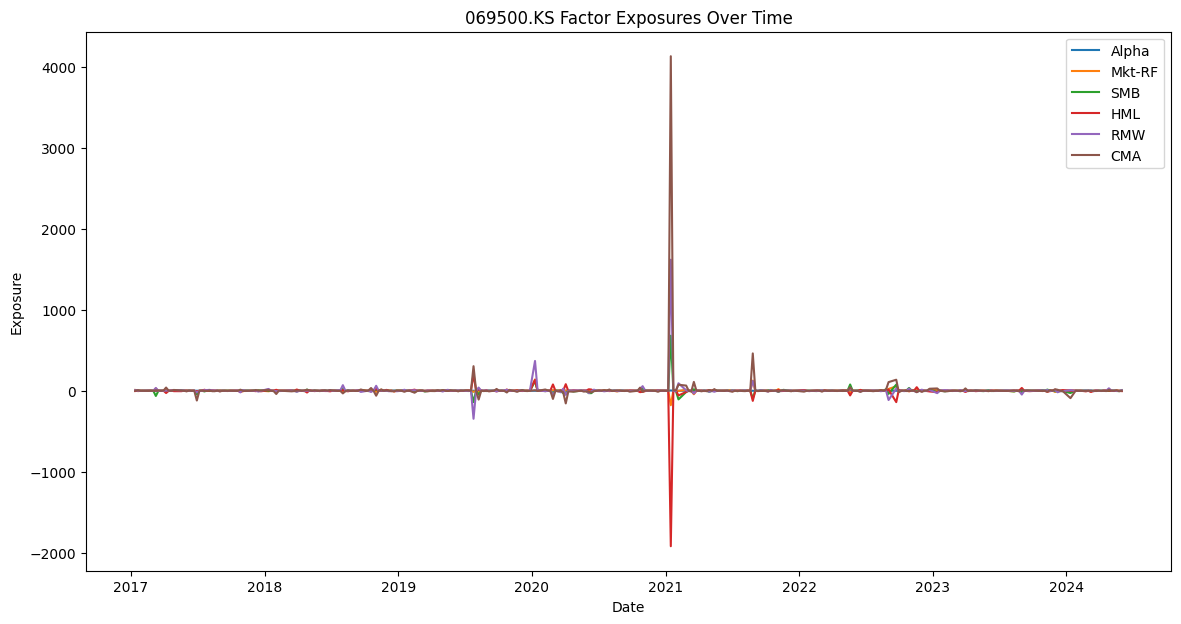

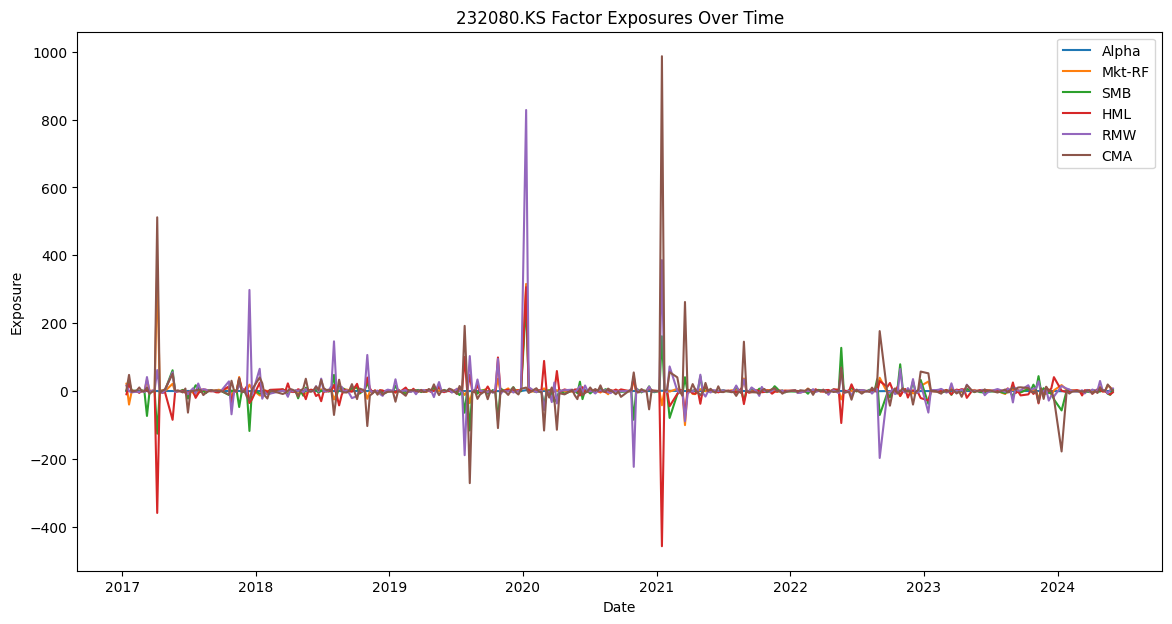

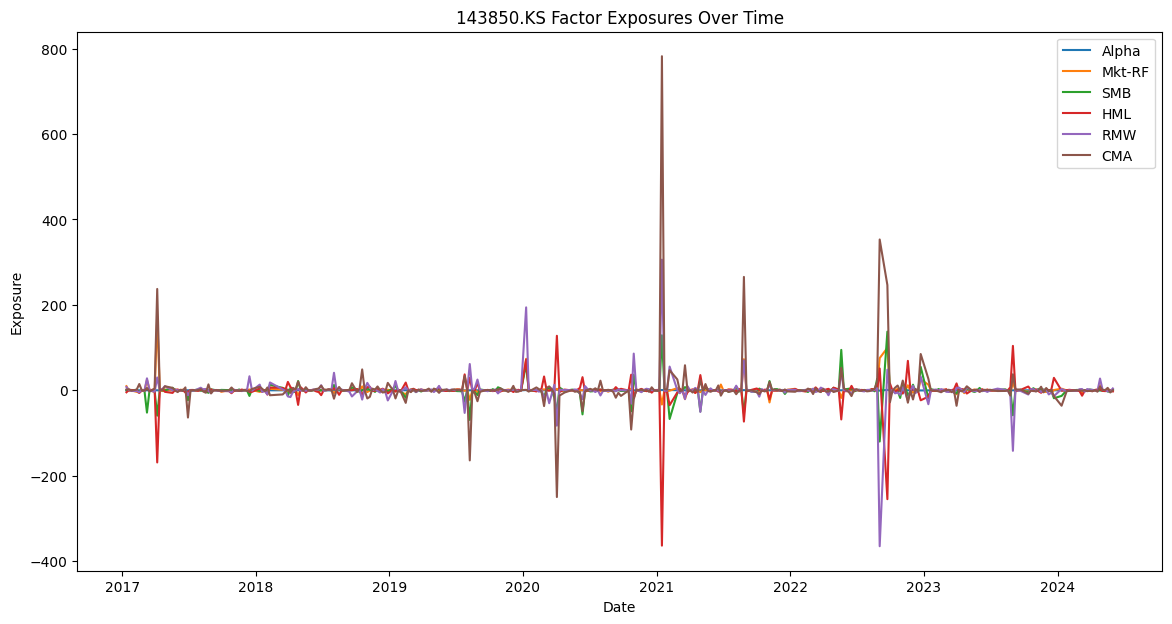

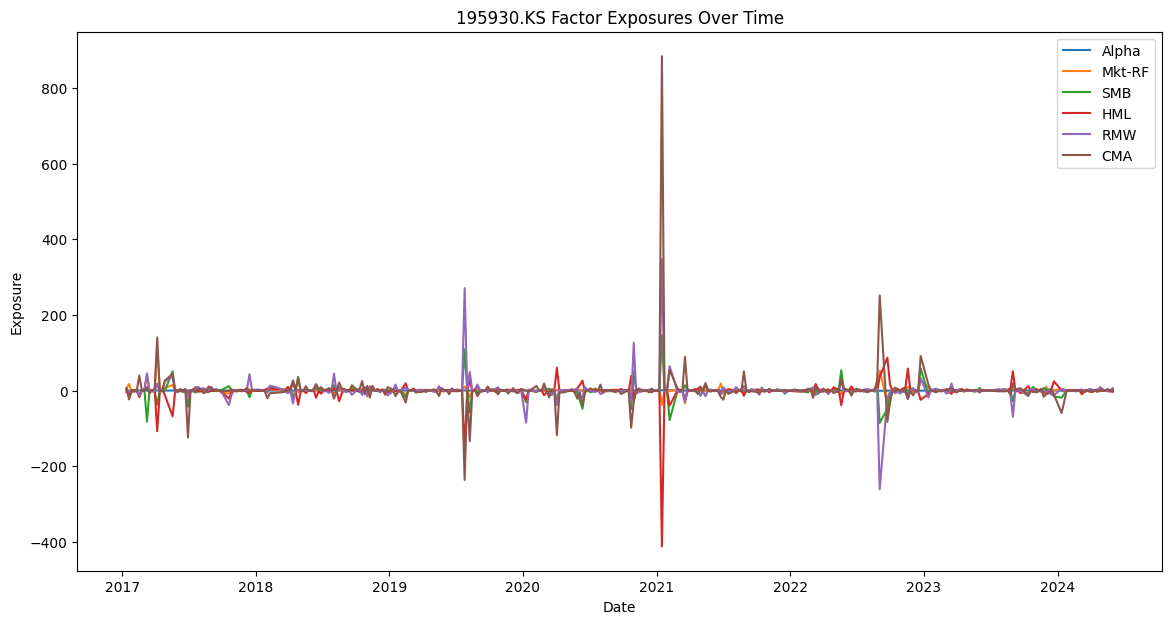

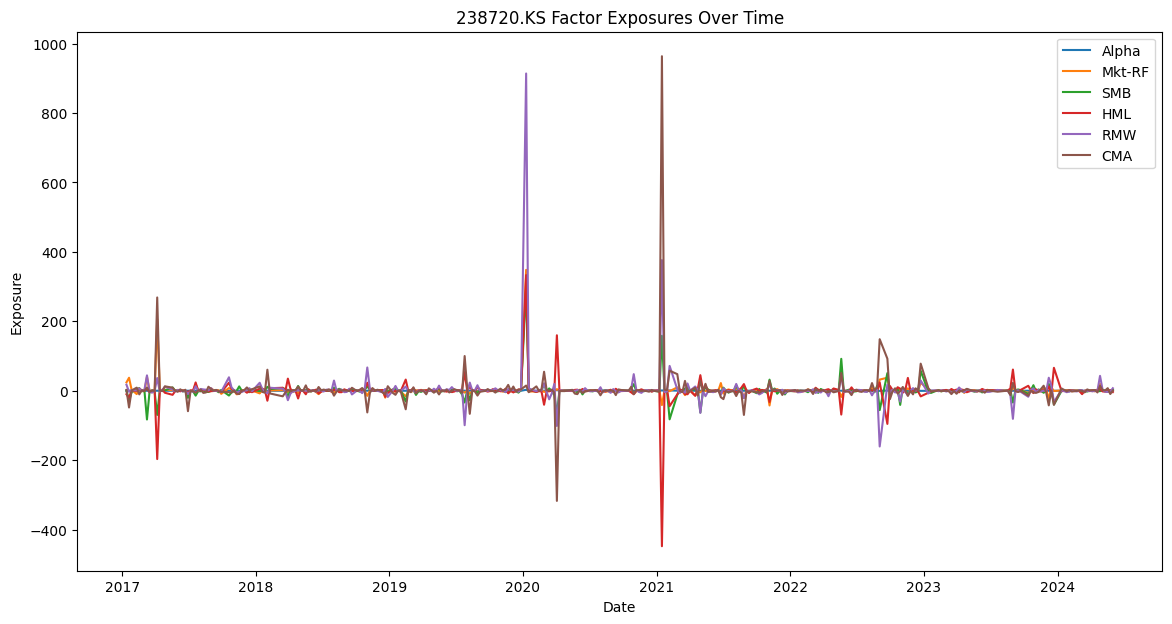

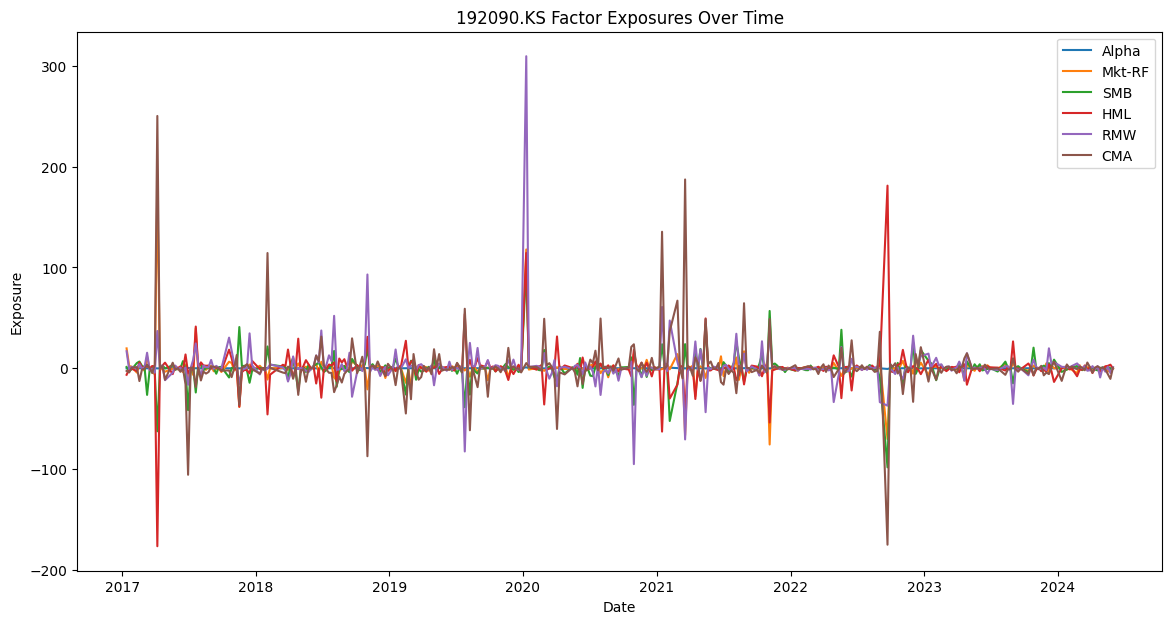

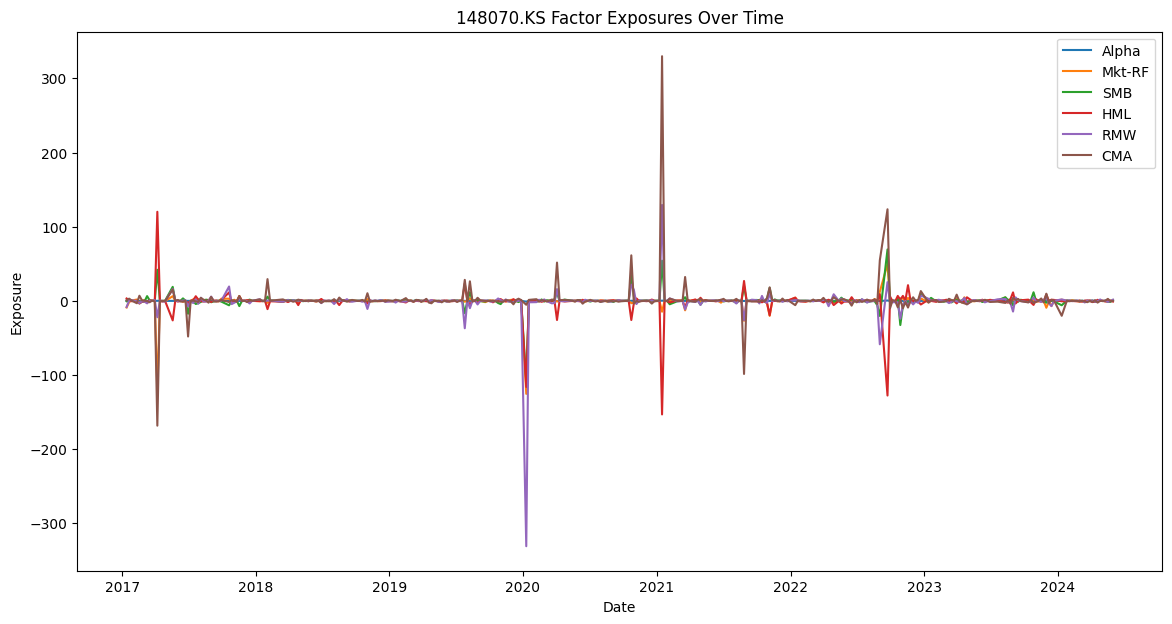

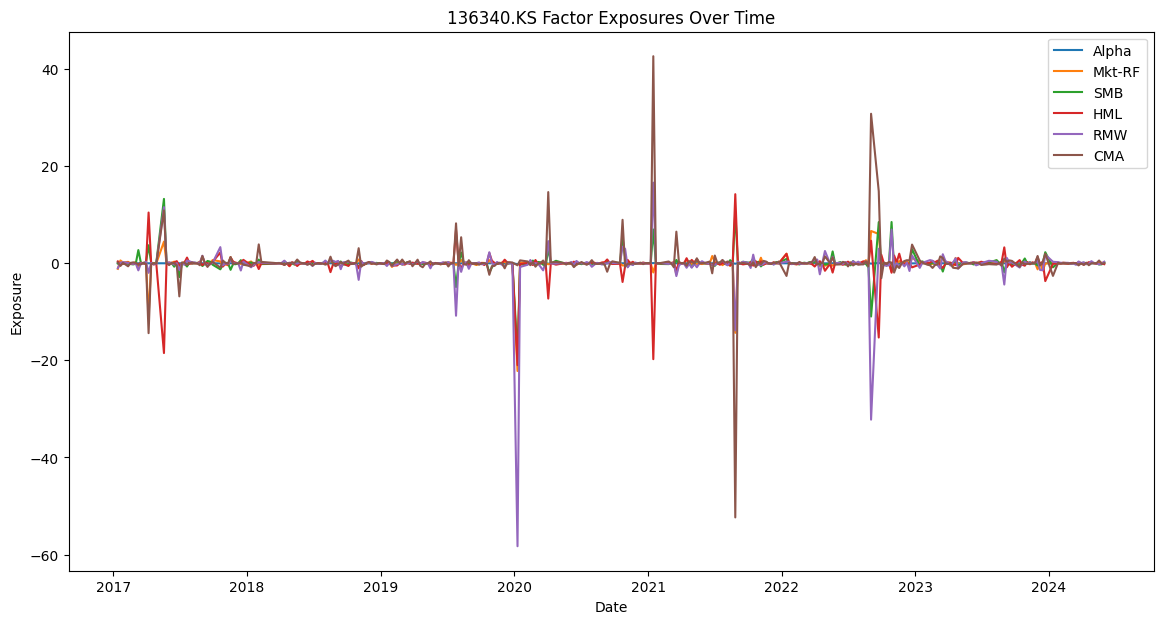

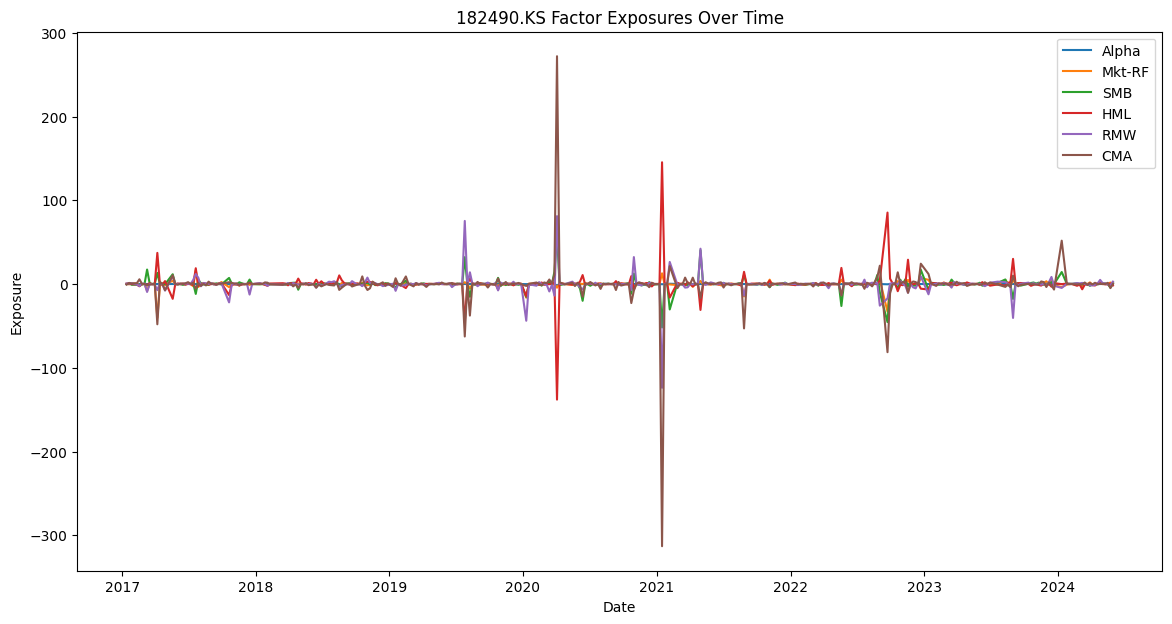

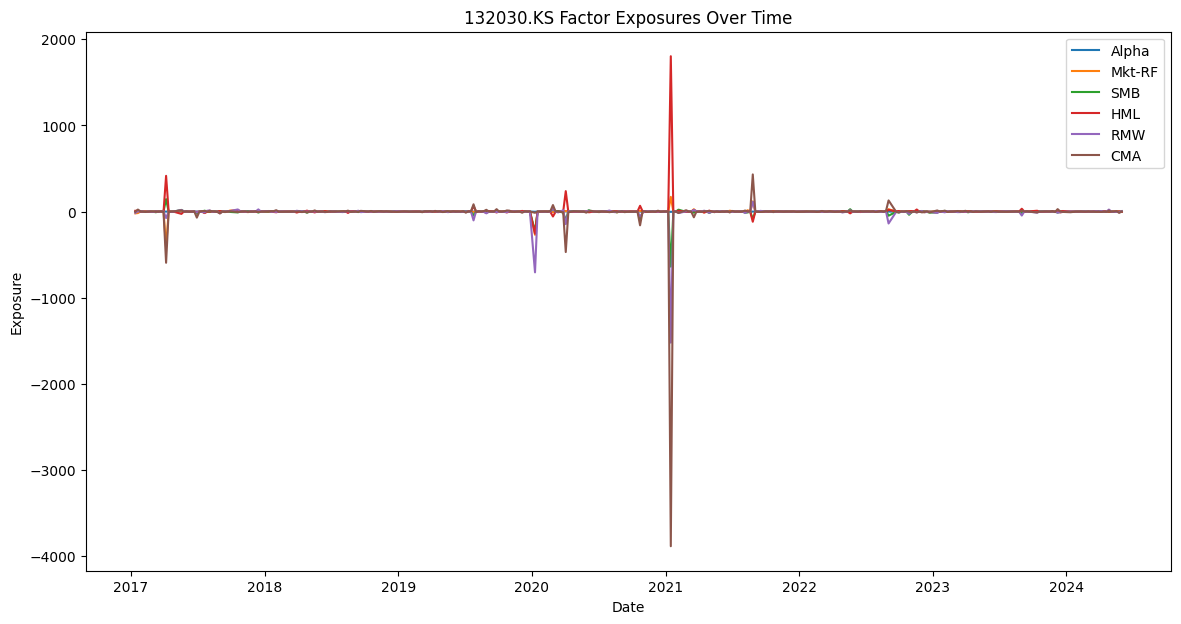

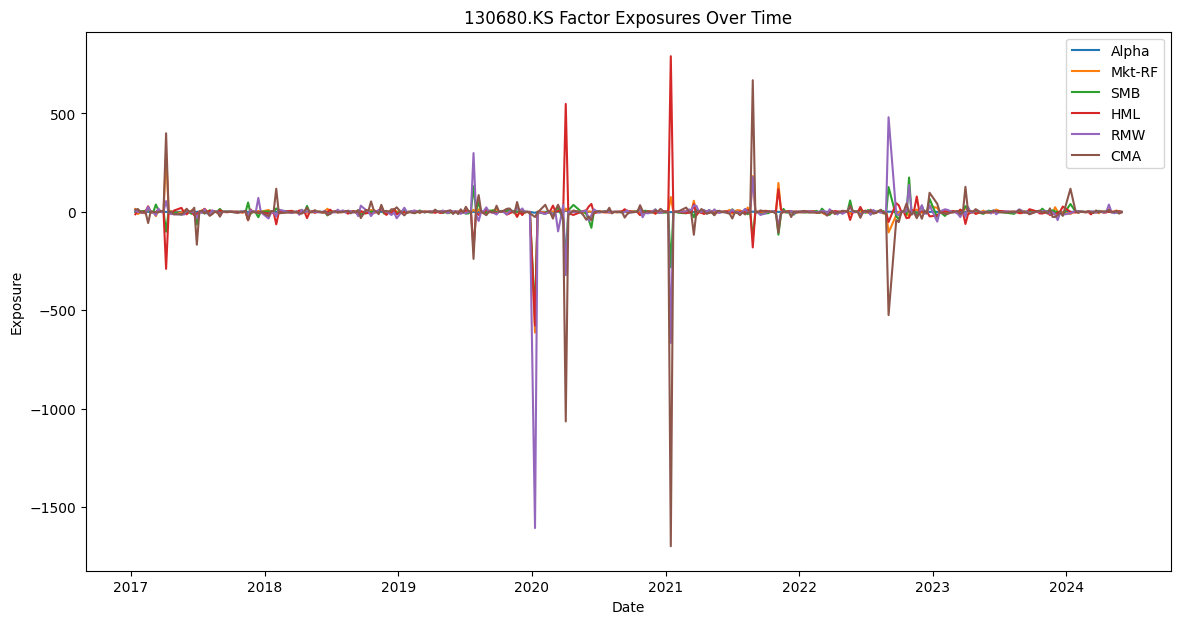

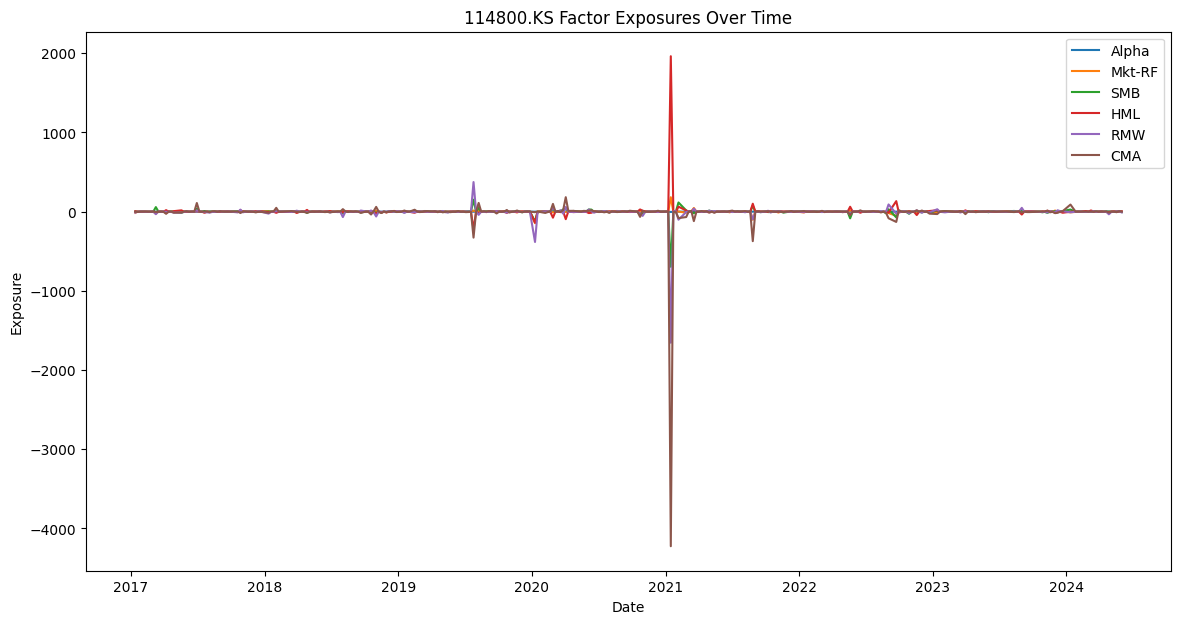

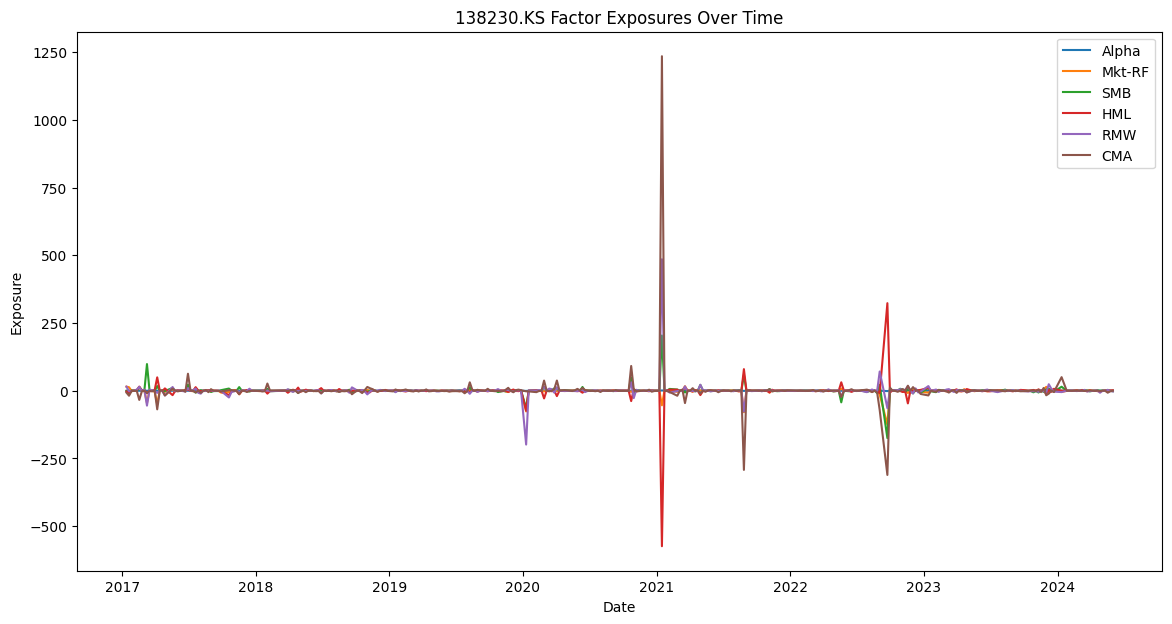

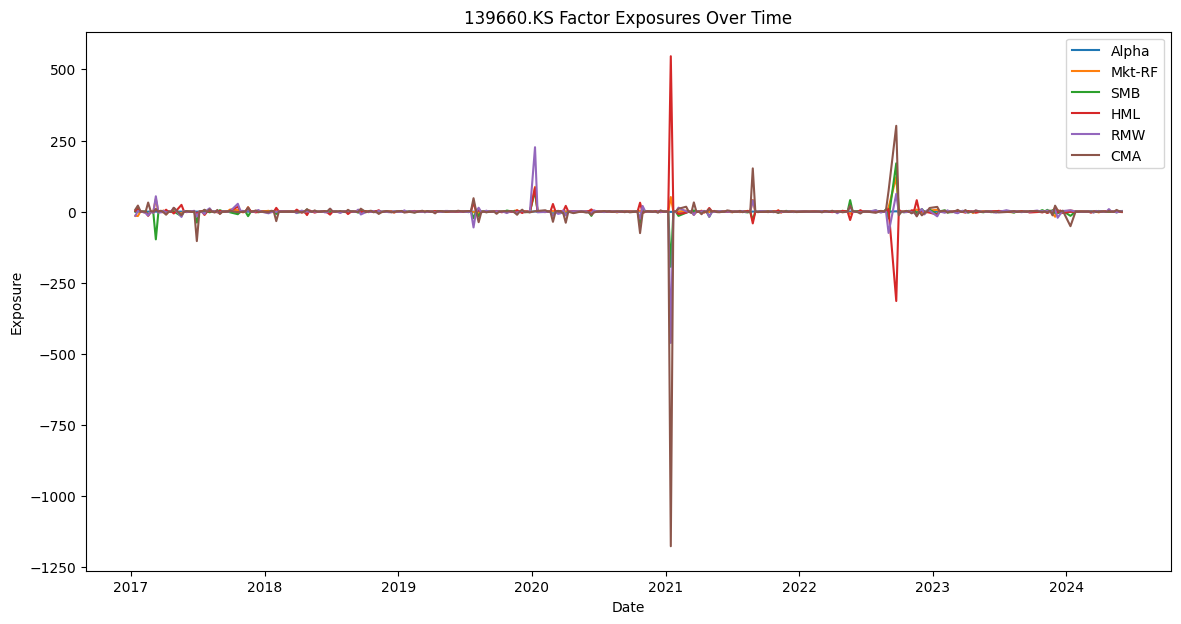

In [ ]:
# 결과를 시각화
for ticker in etf_tickers:
    ticker_data = all_factors_df[all_factors_df['Ticker'] == ticker]
    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data['Date'], ticker_data['Alpha'], label='Alpha')
    plt.plot(ticker_data['Date'], ticker_data['Mkt-RF'], label='Mkt-RF')
    plt.plot(ticker_data['Date'], ticker_data['SMB'], label='SMB')
    plt.plot(ticker_data['Date'], ticker_data['HML'], label='HML')
    plt.plot(ticker_data['Date'], ticker_data['RMW'], label='RMW')
    plt.plot(ticker_data['Date'], ticker_data['CMA'], label='CMA')
    plt.xlabel('Date')
    plt.ylabel('Exposure')
    plt.title(f'{ticker} Factor Exposures Over Time')
    plt.legend()
    plt.show()

## 8. Fama-French 5 요인 모델을 사용하여 예측한 가격과 실제 가격 비교

[*********************100%%**********************]  1 of 1 completed


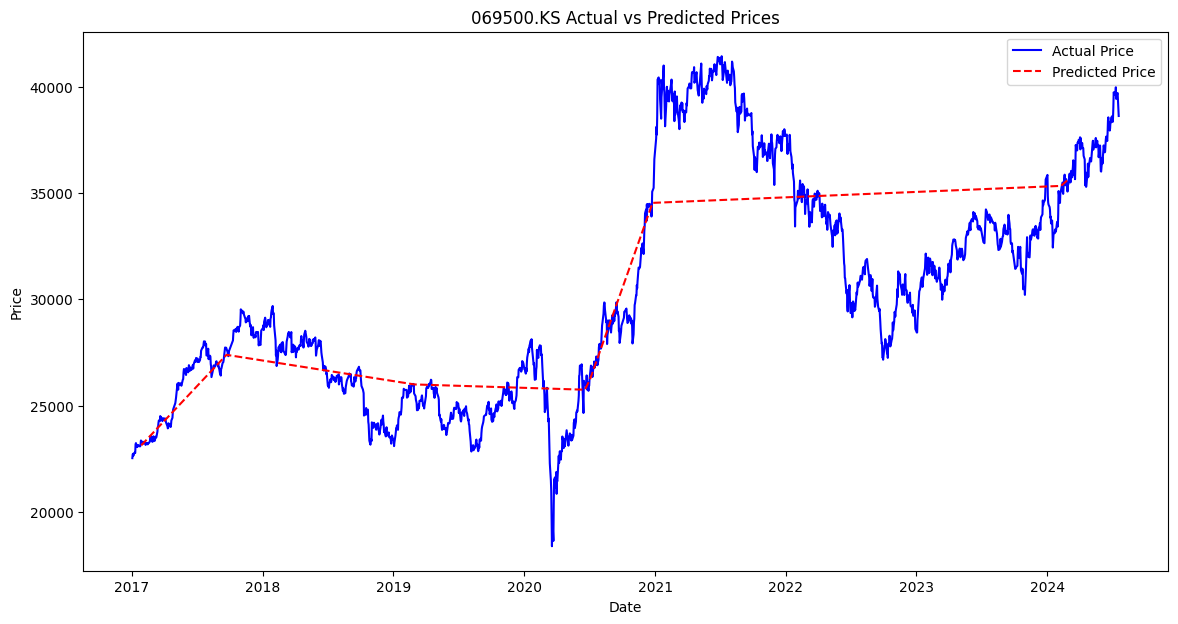

[*********************100%%**********************]  1 of 1 completed


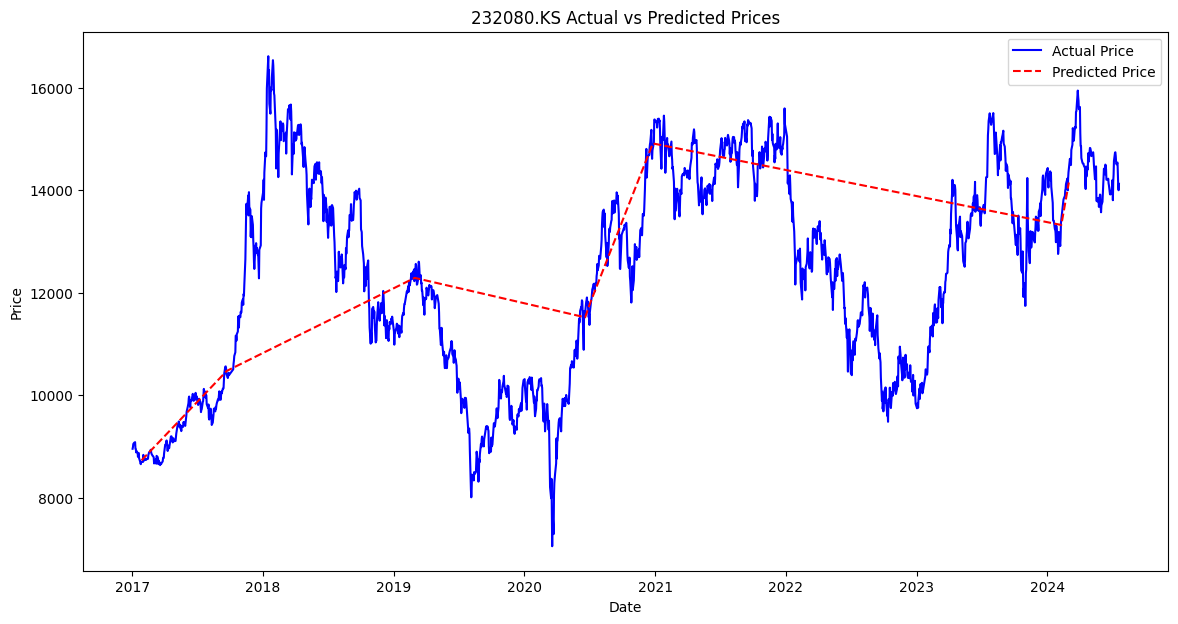

[*********************100%%**********************]  1 of 1 completed


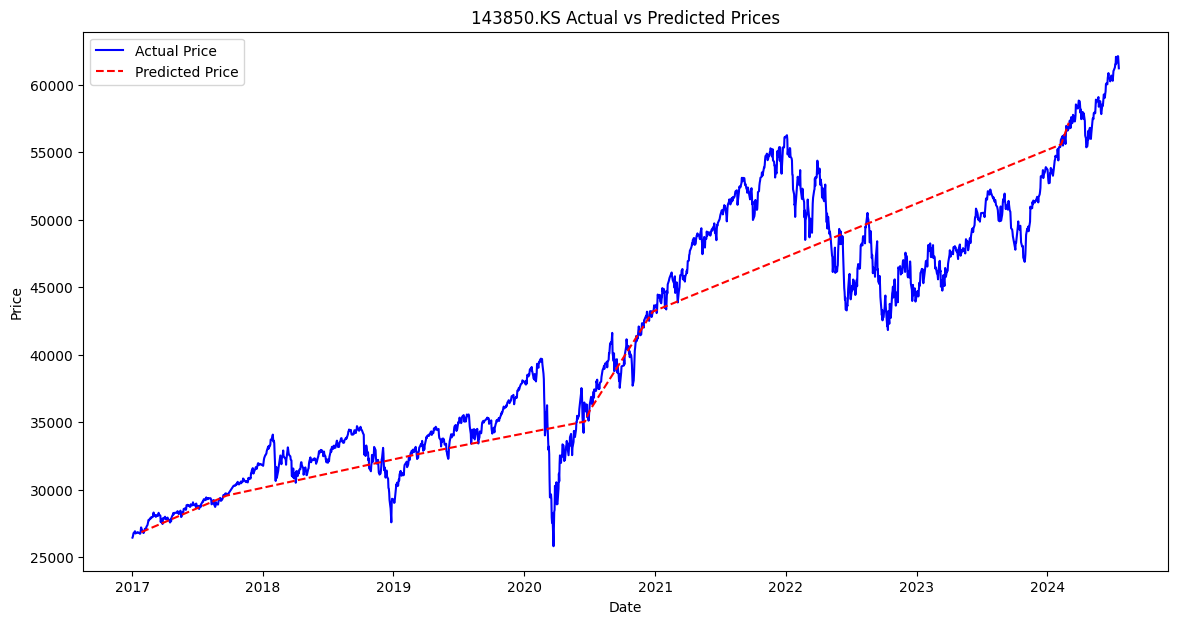

[*********************100%%**********************]  1 of 1 completed


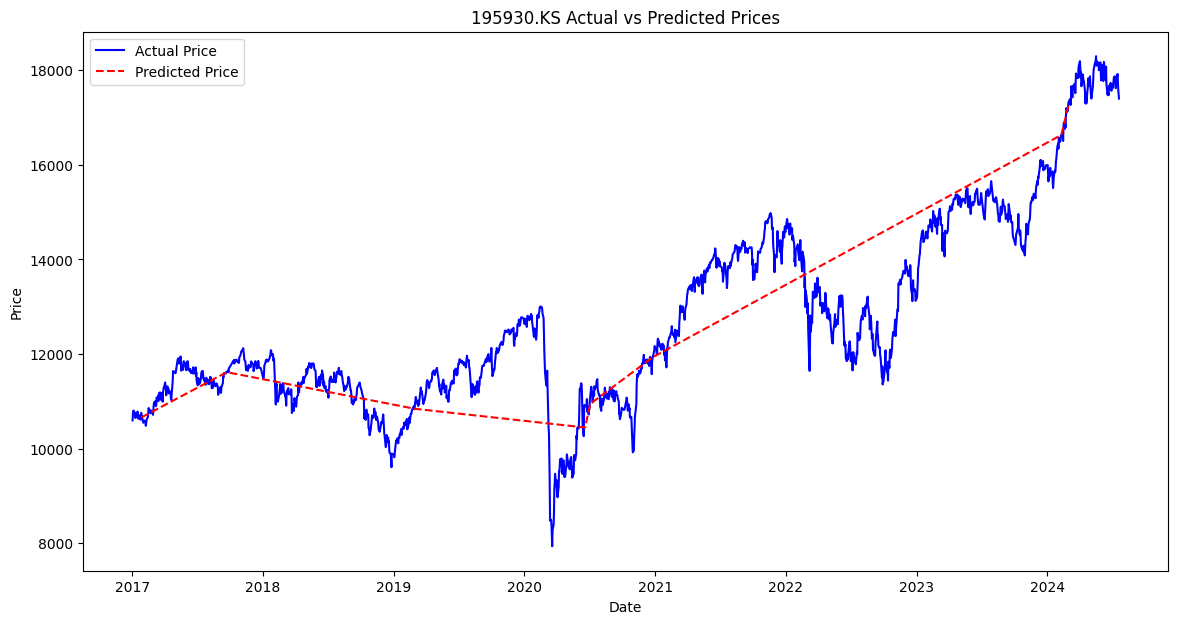

[*********************100%%**********************]  1 of 1 completed


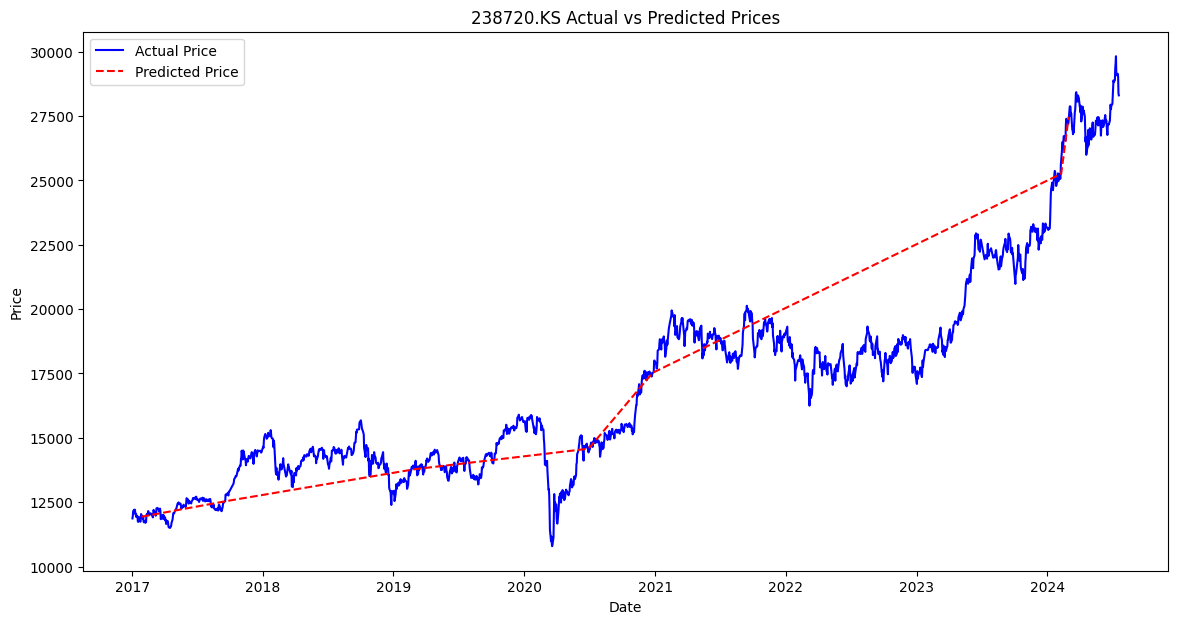

[*********************100%%**********************]  1 of 1 completed


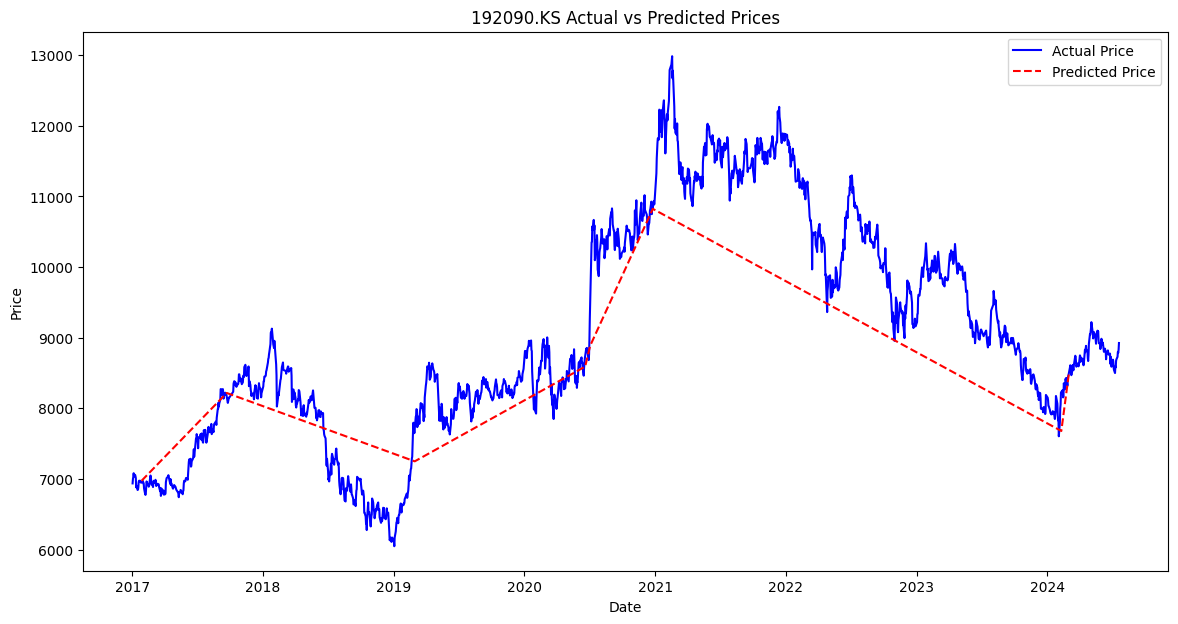

[*********************100%%**********************]  1 of 1 completed


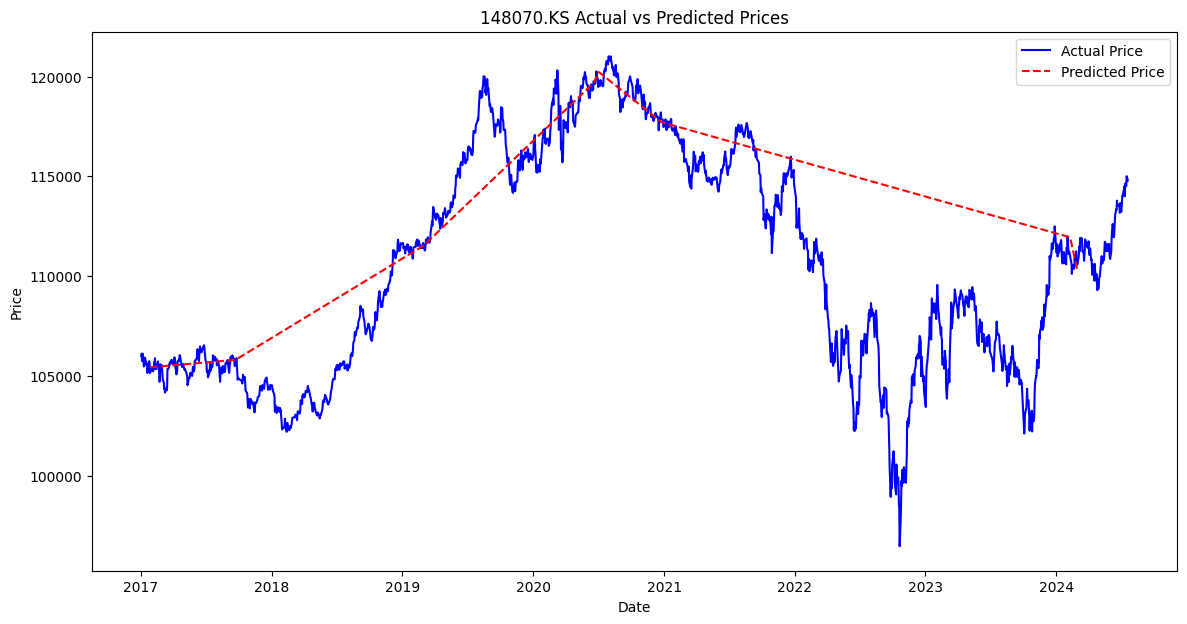

[*********************100%%**********************]  1 of 1 completed


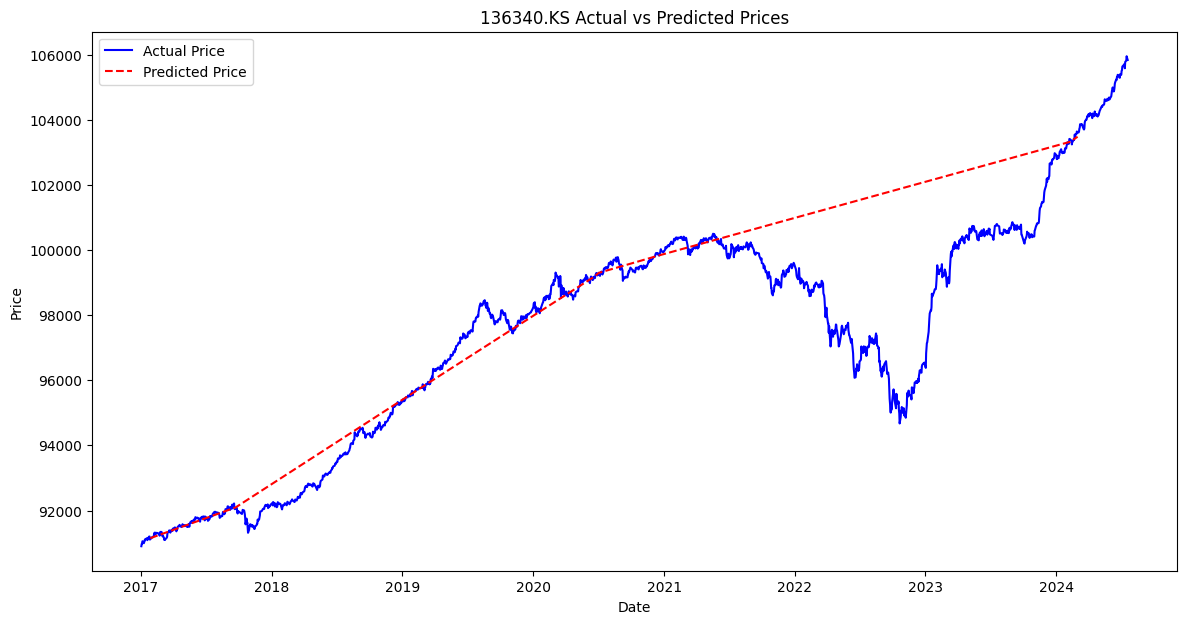

[*********************100%%**********************]  1 of 1 completed


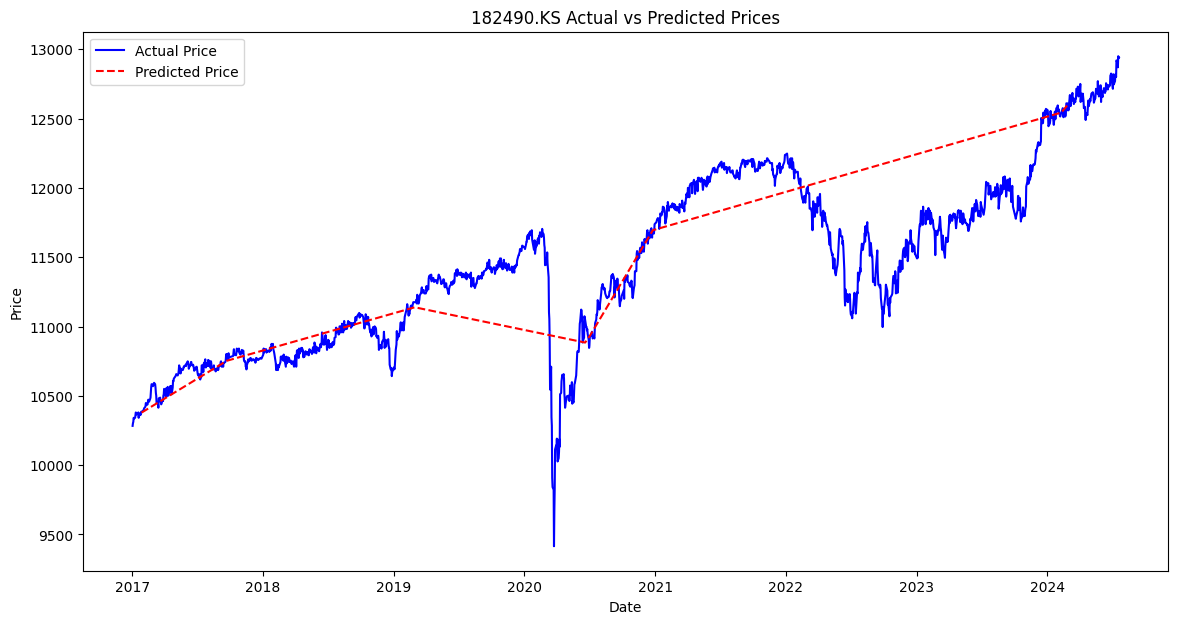

[*********************100%%**********************]  1 of 1 completed


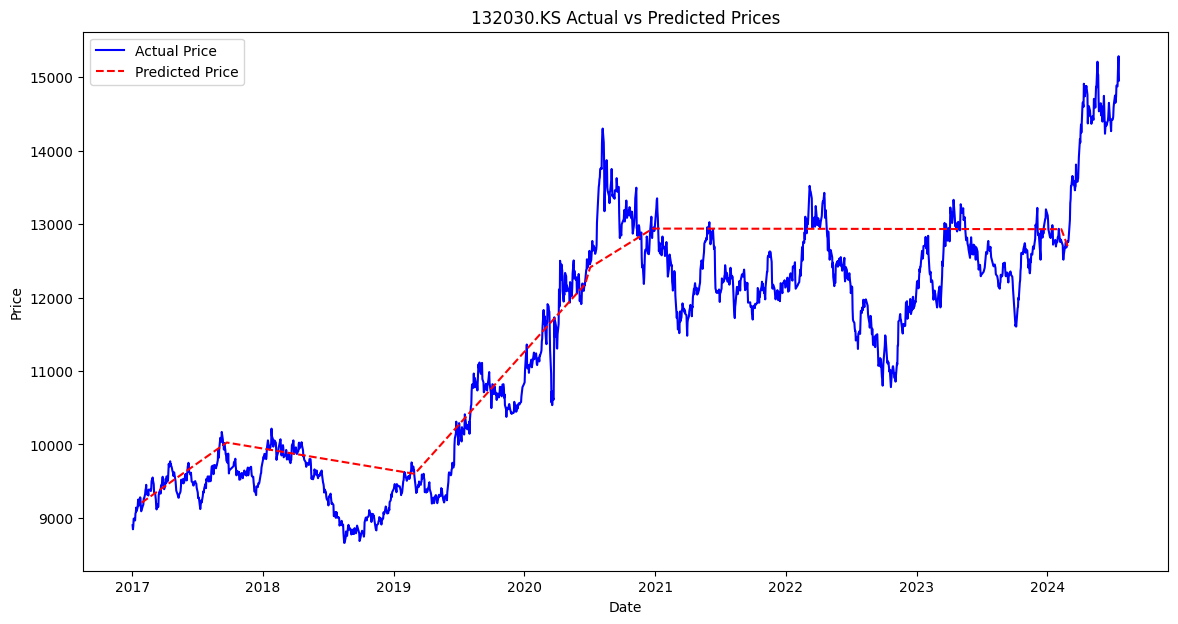

[*********************100%%**********************]  1 of 1 completed


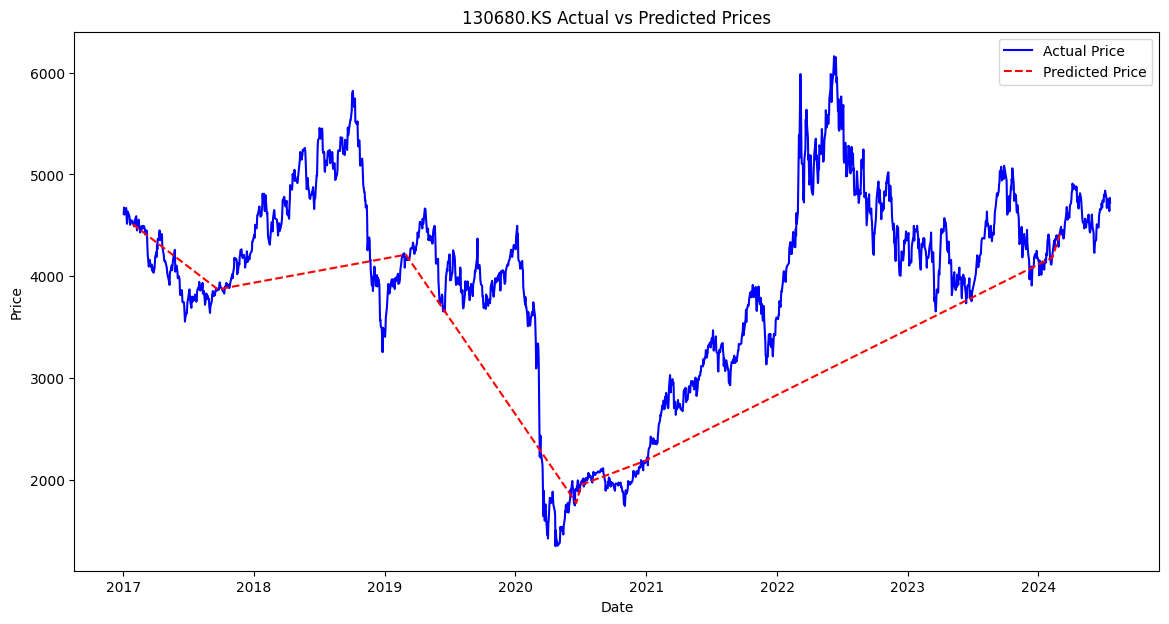

[*********************100%%**********************]  1 of 1 completed


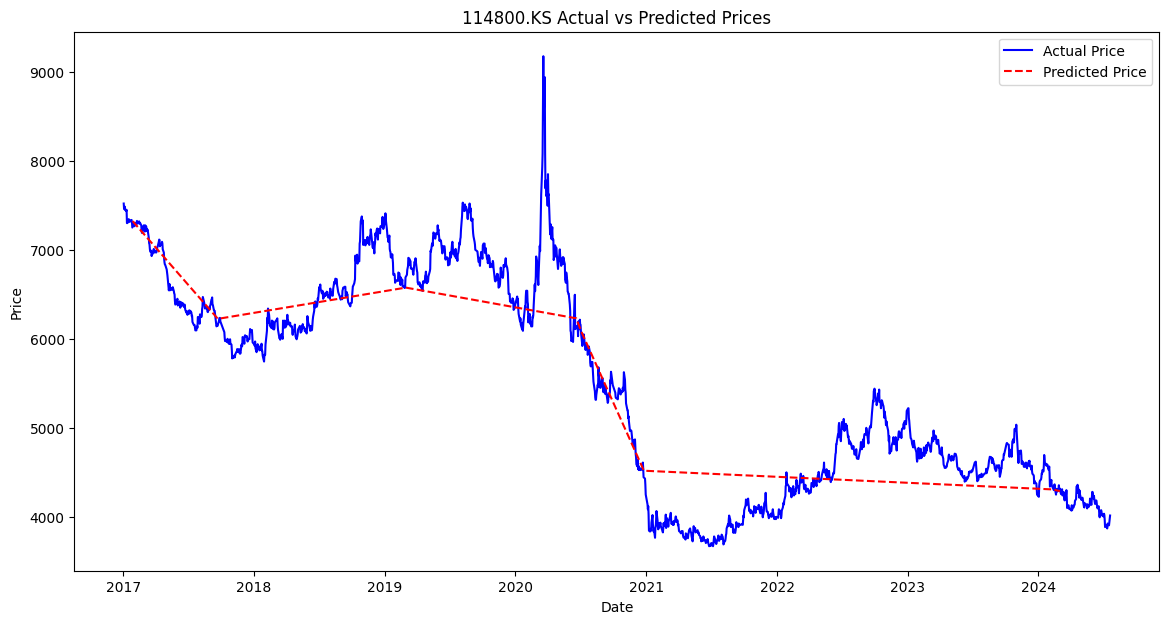

[*********************100%%**********************]  1 of 1 completed


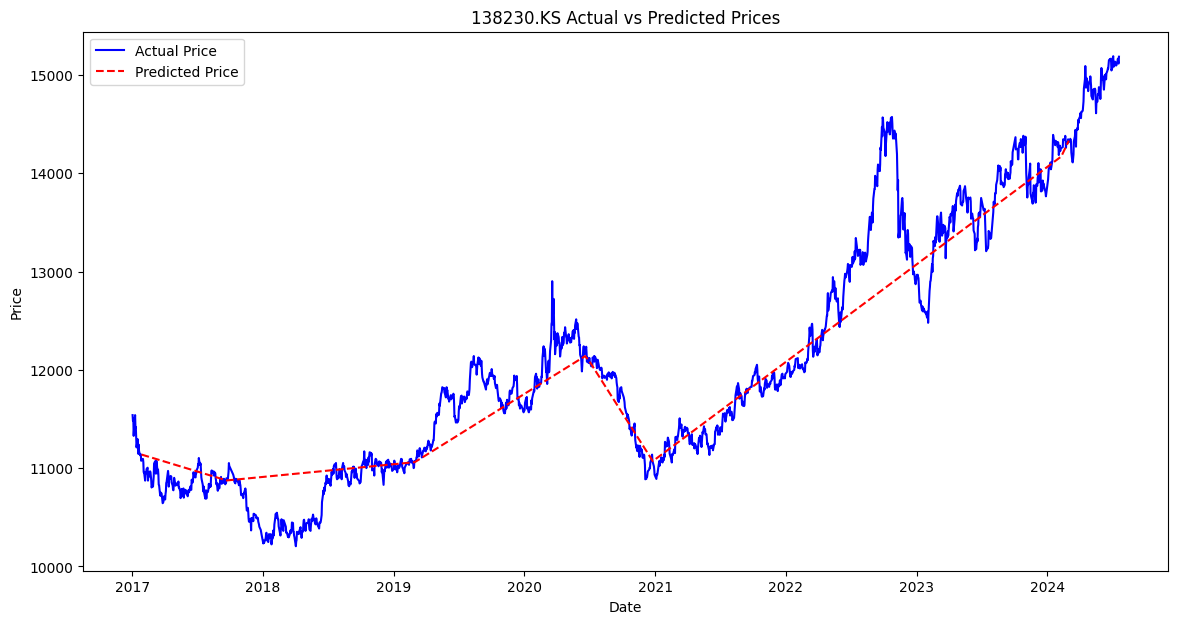

[*********************100%%**********************]  1 of 1 completed


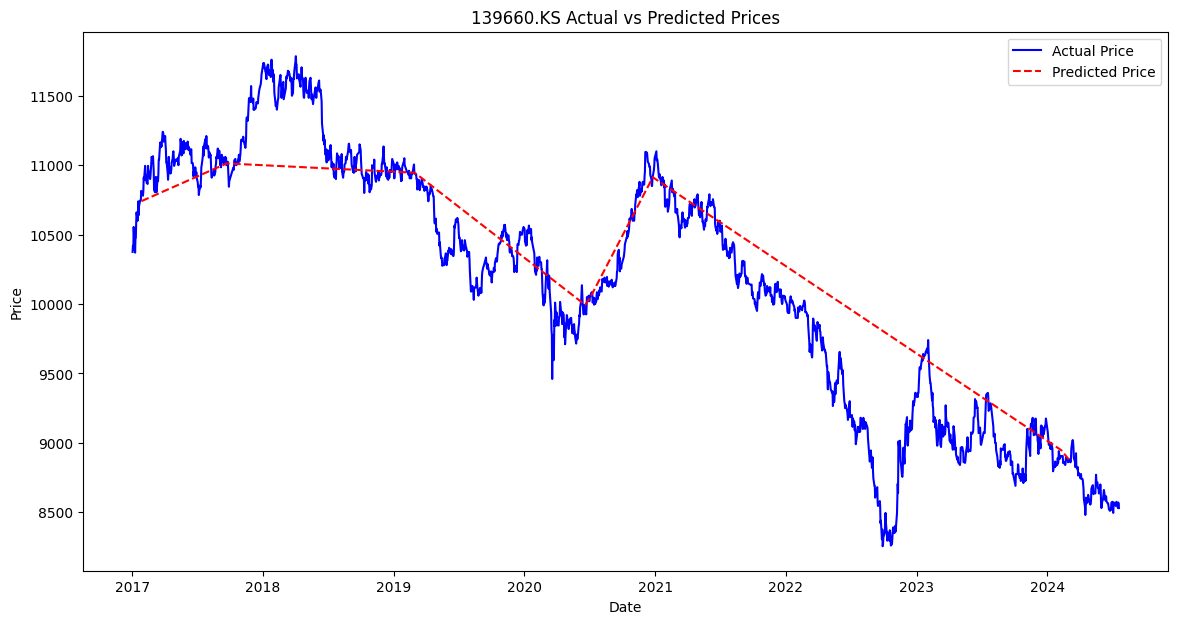

In [ ]:
for ticker in etf_tickers:
    # 특정 ETF의 팩터 노출도 데이터를 가져와서 날짜를 인덱스로 설정
    ticker_data = all_factors_df[all_factors_df['Ticker'] == ticker]
    ticker_data.set_index('Date', inplace=True)

    # ETF 주가 데이터를 가져와서 예측 가격 열을 추가
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data['Predicted'] = np.nan

    for date in ticker_data.index:
        # 현재 주의 시작 날짜 설정
        start_period = date - pd.DateOffset(weeks=1)

        # 현재 주의 Fama-French 팩터 데이터를 선택
        window_ff_data = ff_data.loc[start_period:date]

        # 데이터가 충분하지 않으면 건너뜀
        if len(window_ff_data) < 5:
            continue

        # 해당 날짜의 팩터 노출도와 알파 값을 가져옴
        factors = ticker_data.loc[date, ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].values
        alpha = ticker_data.loc[date, 'Alpha']

        # 팩터 노출도와 Fama-French 팩터 데이터를 이용해 예측 수익률 계산
        predicted_return = alpha + np.dot(factors, window_ff_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].mean().values)

        # 이전 주의 종가를 가져옴
        previous_close = stock_data.loc[start_period, 'Adj Close'] if start_period in stock_data.index else np.nan

        # 이전 종가가 유효하면 예측 가격을 계산하여 저장
        if not np.isnan(previous_close):
            stock_data.loc[date, 'Predicted'] = previous_close * (1 + predicted_return)

    # 실제 가격과 예측 가격을 시각화
    plt.figure(figsize=(14, 7))
    plt.plot(stock_data.index, stock_data['Adj Close'], label='Actual Price', color='blue')
    plt.plot(stock_data.index, stock_data['Predicted'], label='Predicted Price', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{ticker} Actual vs Predicted Prices')
    plt.legend()
    plt.show()